<p style="text-align:center"> 
<a href="https://skills.network" target="_blank"> 
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="300" alt="Skills Network Logo"> 
</a>
</p>

# <h1 align="center"><font size="7"><strong>Final project</strong></font></h1>
## <h2 align= "center"><font size="6.8">**Homes for sale in King County, USA**</font></h2>

<hr>

# Part 5: Feature Engineering and Evaluation

Feature engineering is the art and science of transforming raw data into useful representations that improve a model's predictive capabilities. It is one of the most critical and decisive stages in any machine learning project, especially in tabular problems like this one.

Good feature engineering can improve a model's performance more significantly than modifying or fine-tuning the algorithm. Therefore, I saved this step until last to demonstrate how my skills as a data scientist can positively influence these types of projects.

### We performed a quick EDA again

In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('../data/processed/data_clean.csv')

In [4]:
# Aesthetic settings
sns.set(style='whitegrid', palette='muted')
plt.rcParams["figure.figsize"] = (12, 6)

# Subset of features and target
features = ['sqft_living', 'sqft_lot', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 
            'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 
            'yr_renovated']

target = 'price'

df_subset = df[features + [target]]

As we saw in part 3, we have the following statistics and the set of graphs that show how the data is distributed according to each characteristic of the data set

In [5]:
print(df_subset.describe().T)

                 count           mean            std      min        25%  \
sqft_living    21558.0    2076.573755     910.236773    290.0    1420.50   
sqft_lot       21558.0   15033.969710   41300.758633    520.0    5040.00   
bedrooms       21558.0       3.373451       0.925113      1.0       3.00   
bathrooms      21558.0       2.114396       0.766176      0.5       1.75   
floors         21558.0       1.494155       0.539967      1.0       1.00   
waterfront     21558.0       0.005010       0.070604      0.0       0.00   
view           21558.0       0.226459       0.750328      0.0       0.00   
condition      21558.0       3.408943       0.650104      1.0       3.00   
grade          21558.0       7.654374       1.171038      1.0       7.00   
sqft_above     21558.0    1786.097041     823.591225    290.0    1190.00   
sqft_basement  21558.0     290.476714     439.837084      0.0       0.00   
yr_built       21558.0    1971.046386      29.366964   1900.0    1952.00   
yr_renovated

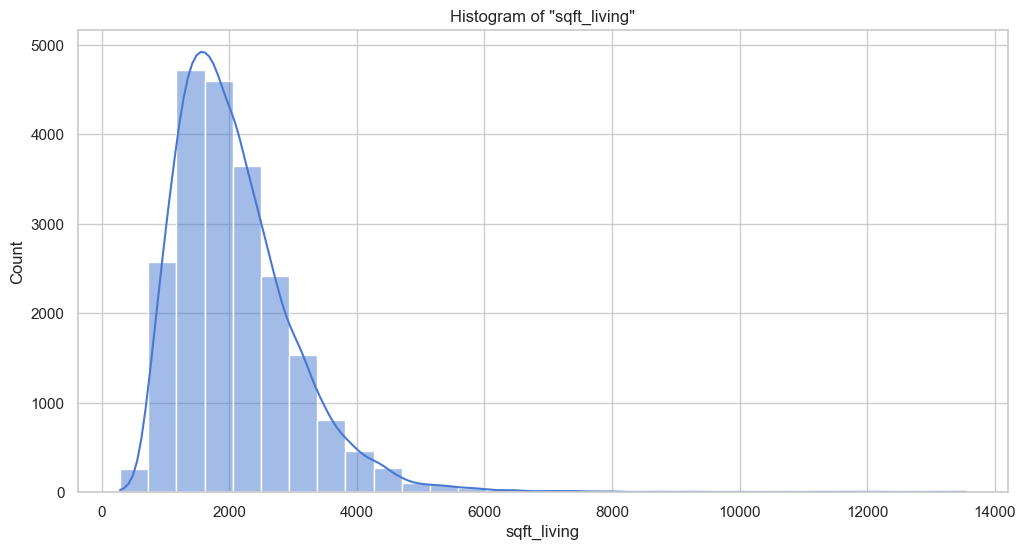

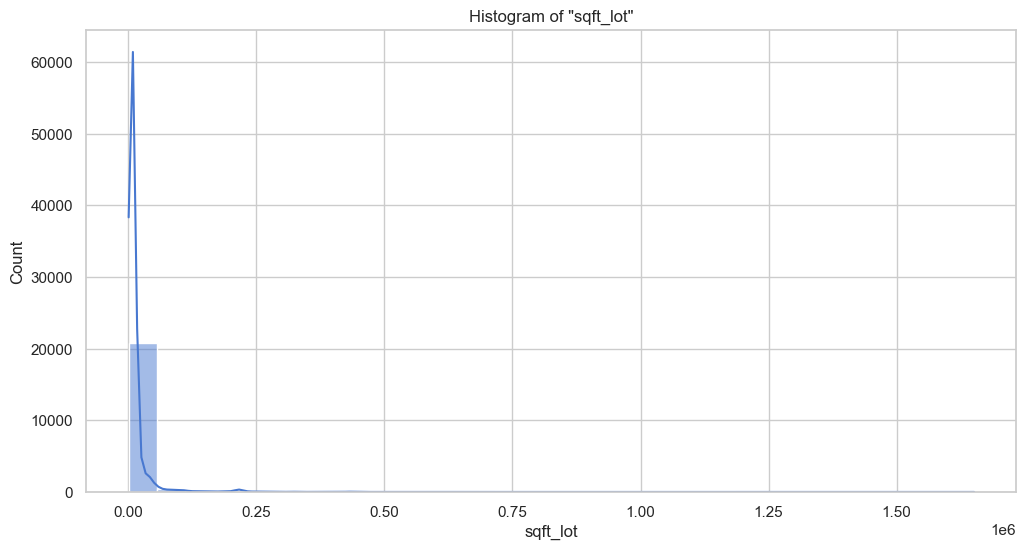

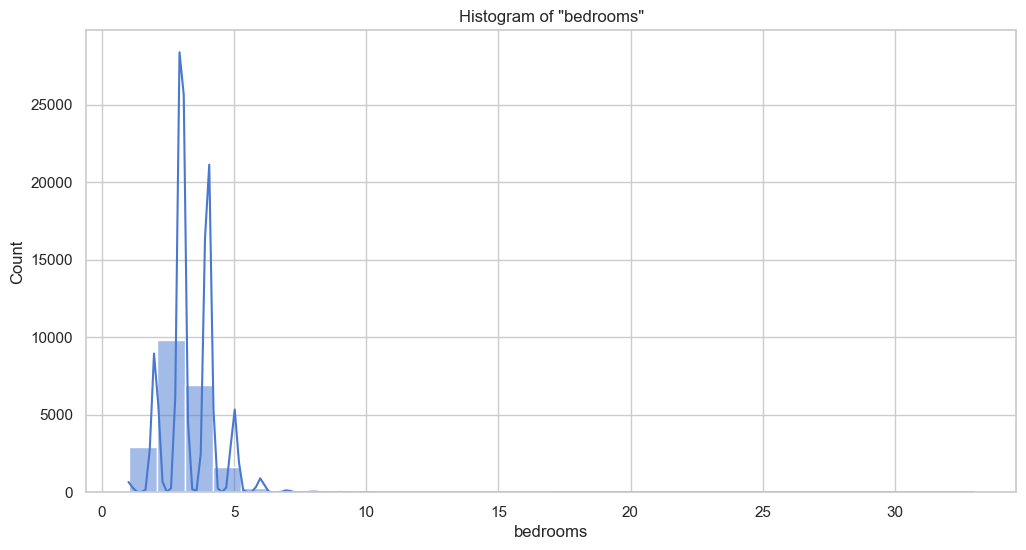

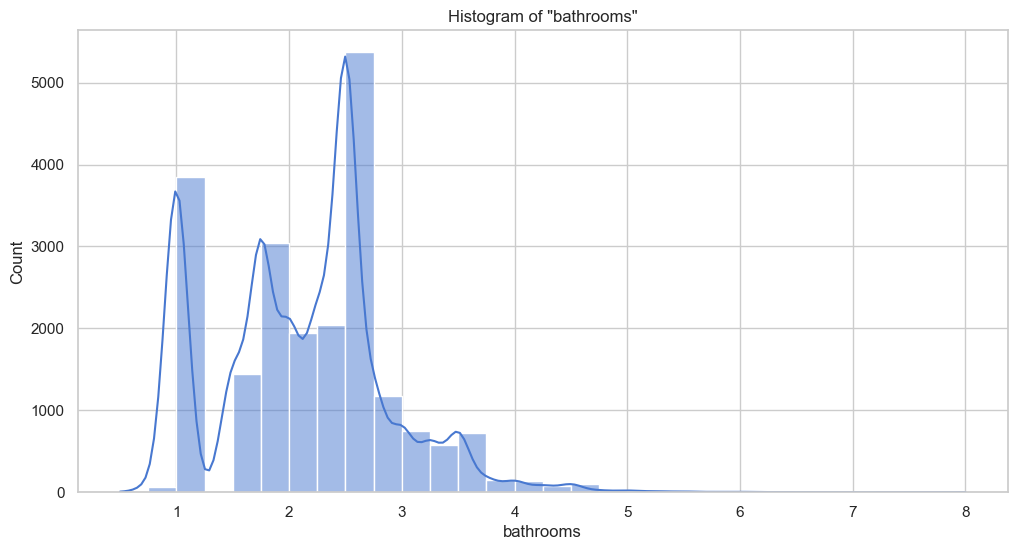

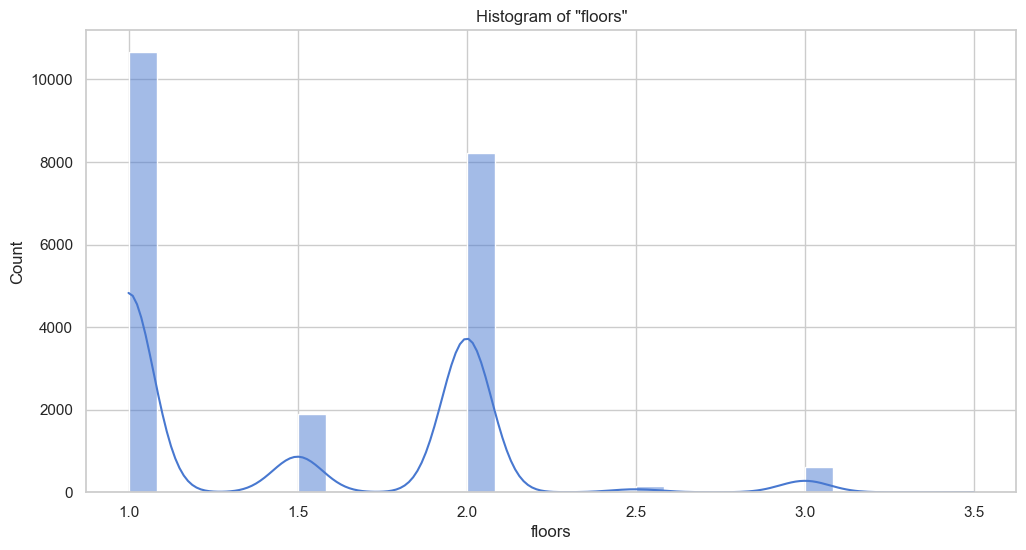

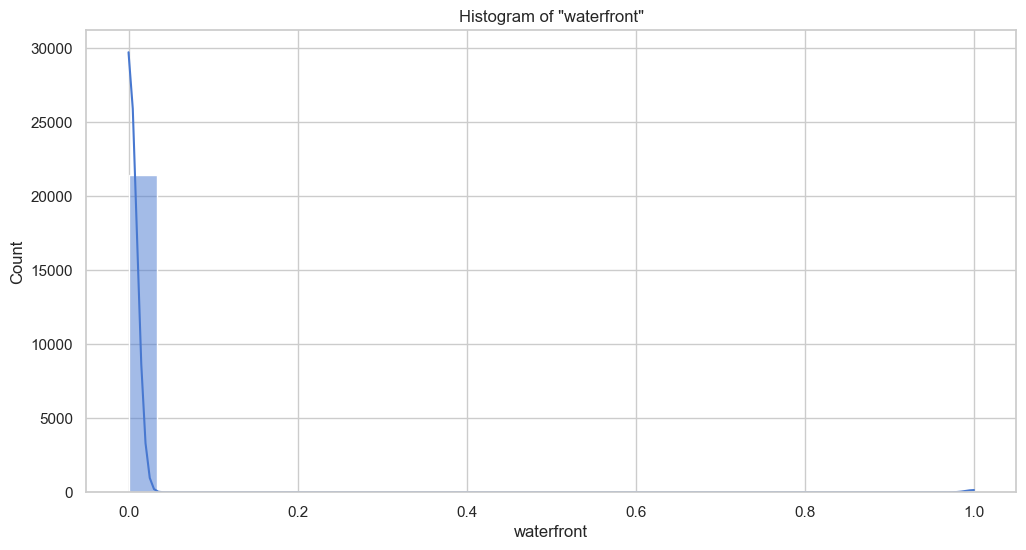

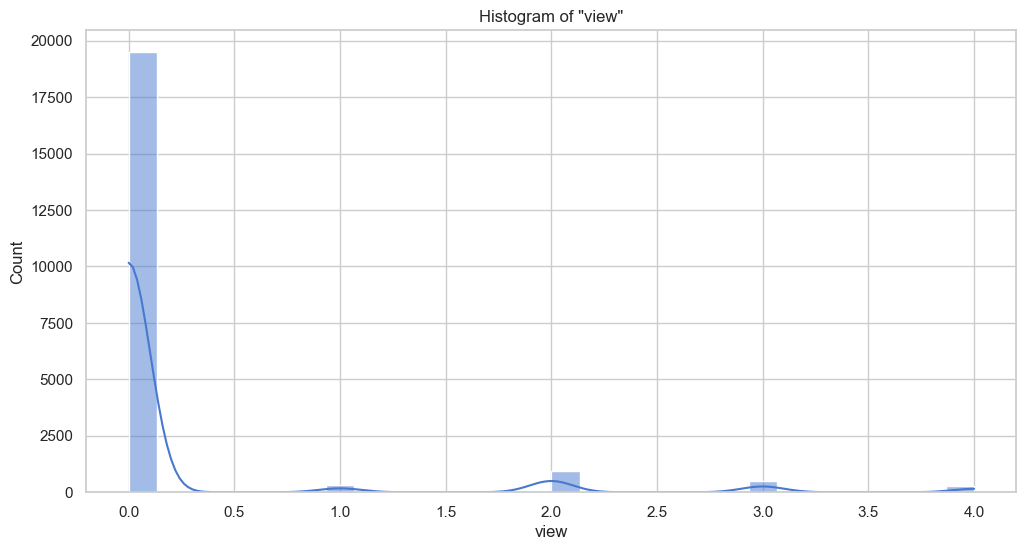

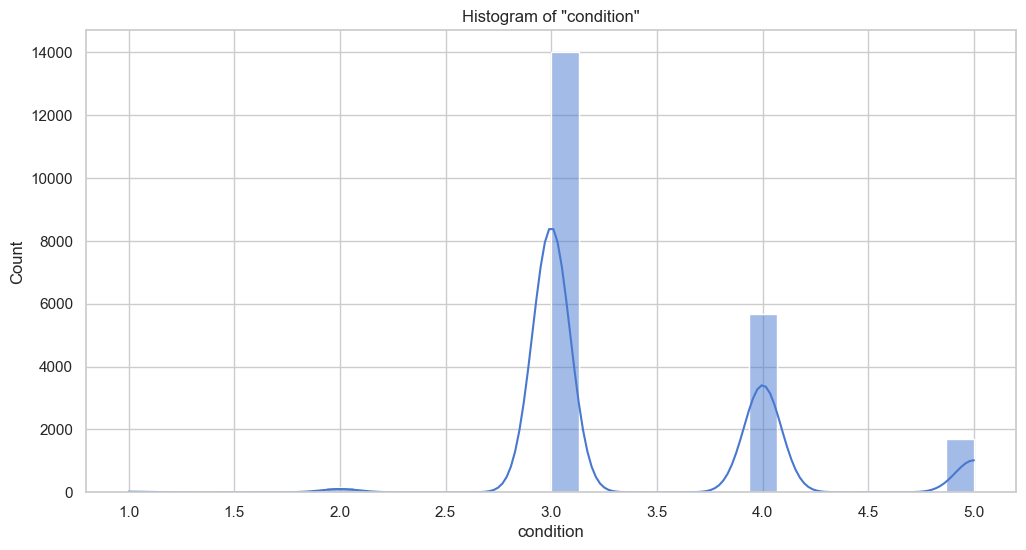

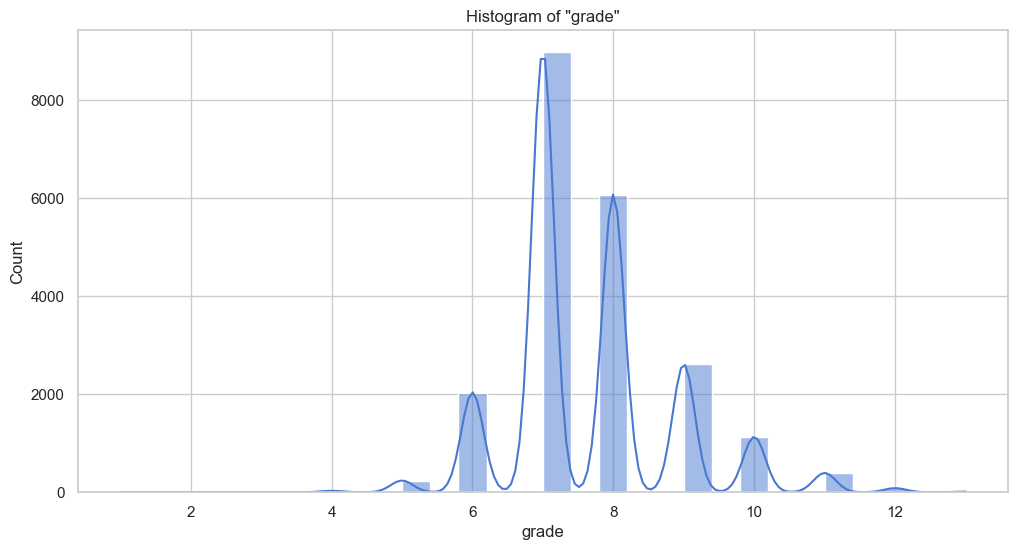

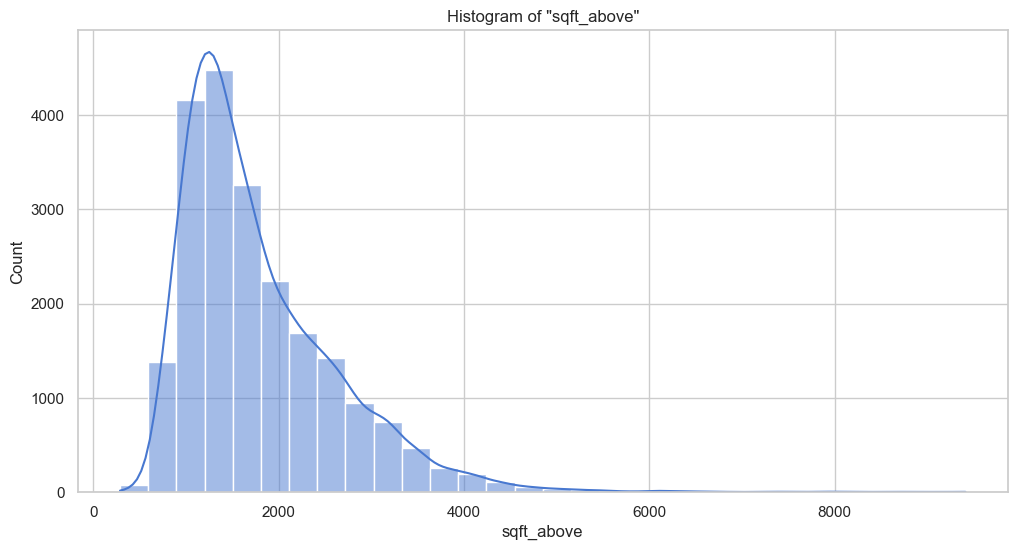

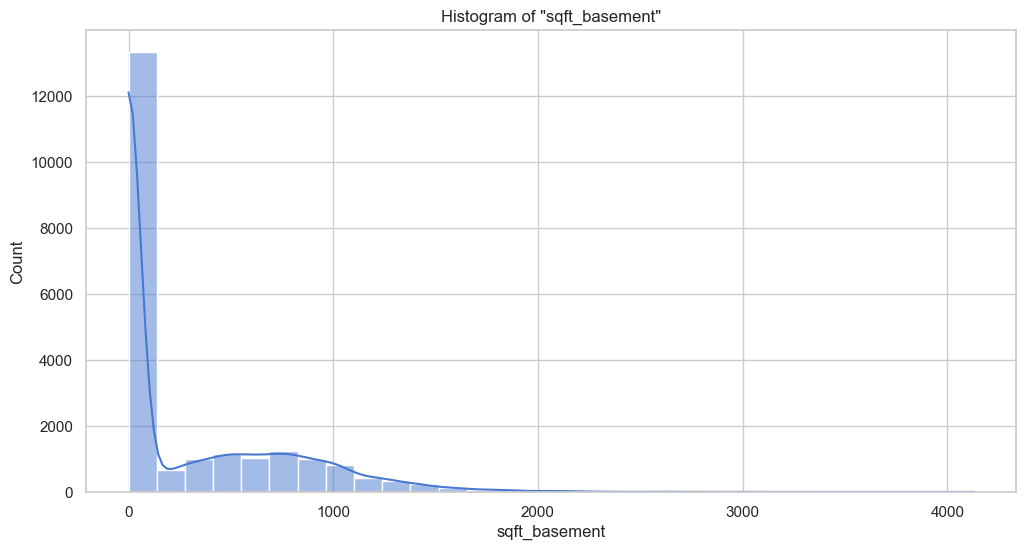

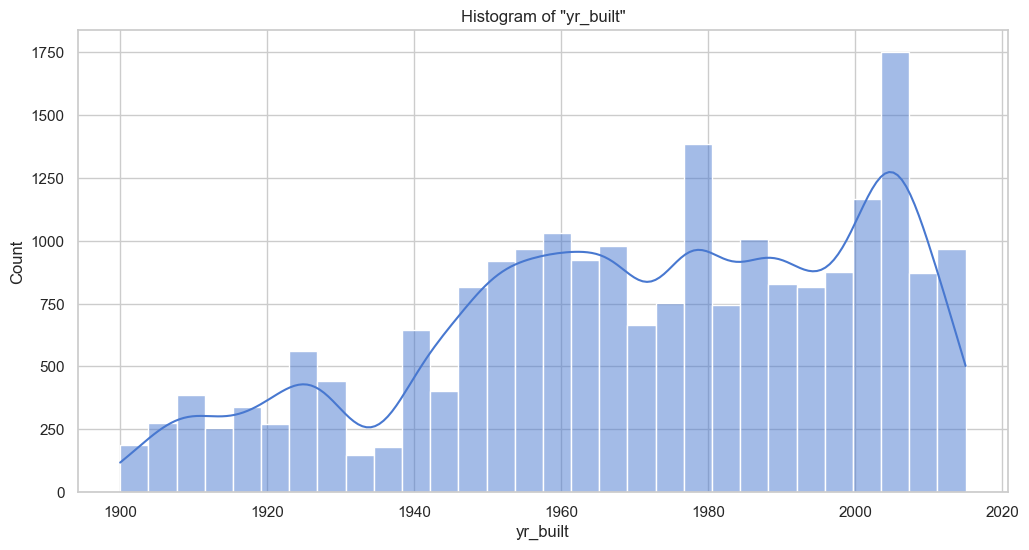

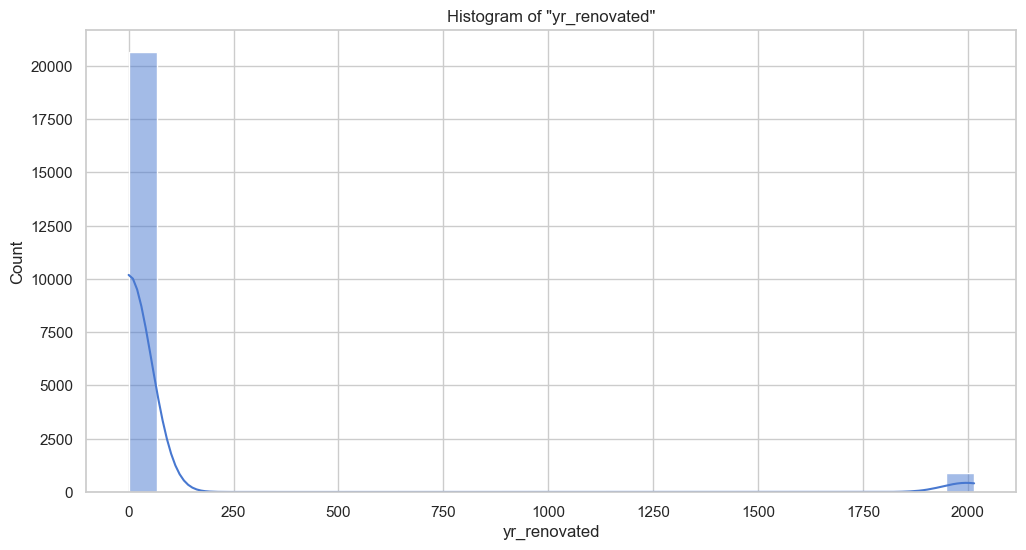

In [6]:
for col in features:
    sns.histplot(df_subset[col], kde=True, bins=30)
    plt.title(f'Histogram of "{col}"')
    plt.xlabel(col)
    # Save the plot as a PNG file.
    plt.savefig(f"../reports/figures/eda/part5-histogram-{col}.png", dpi=300, bbox_inches='tight')
    plt.show()


We observed:

* Highly skewed variables (``sqft_lot``, ``sqft_basement``).

* Possibly numerical categorical variables (``view``, ``condition``, ``grade``).

* Zeros or constant values ​​(``yr_renovated`` could have many zeros).

### We inspect again the outliers in each feature

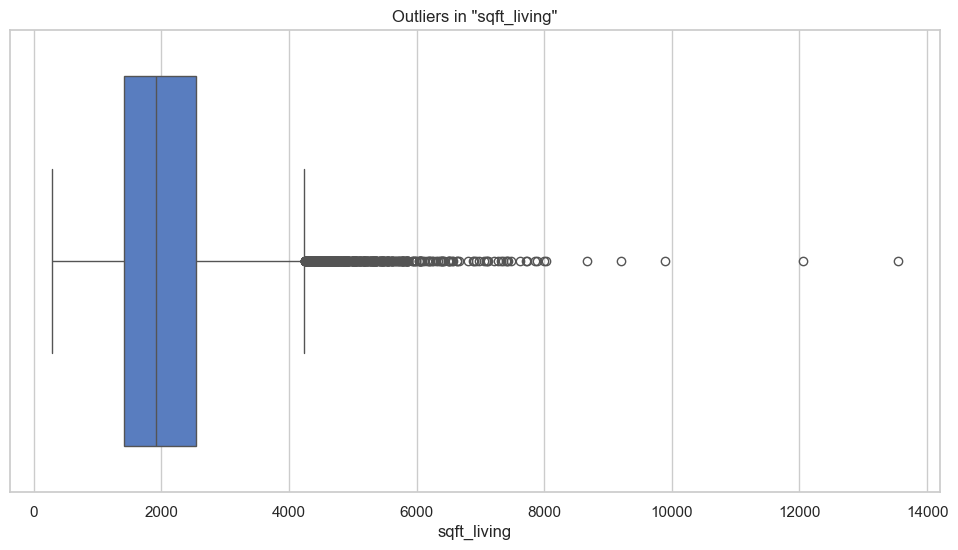

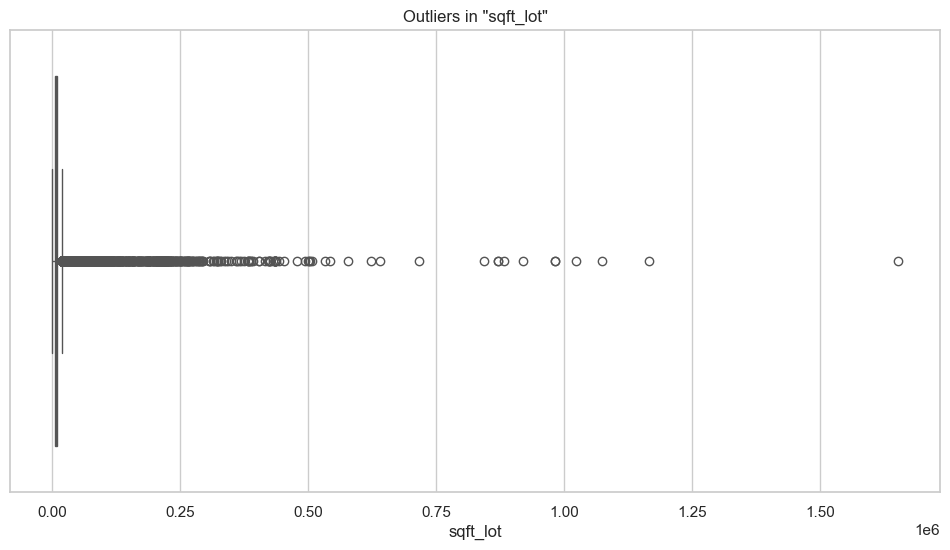

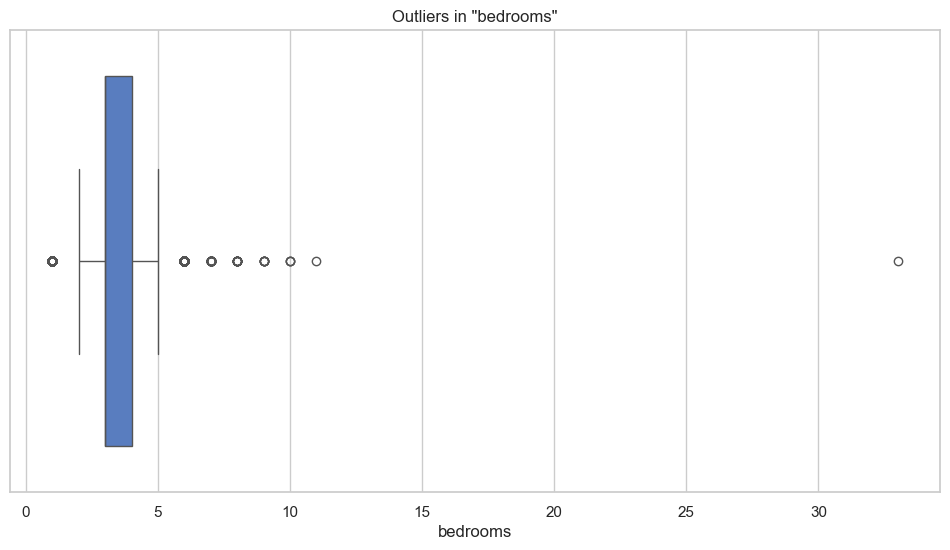

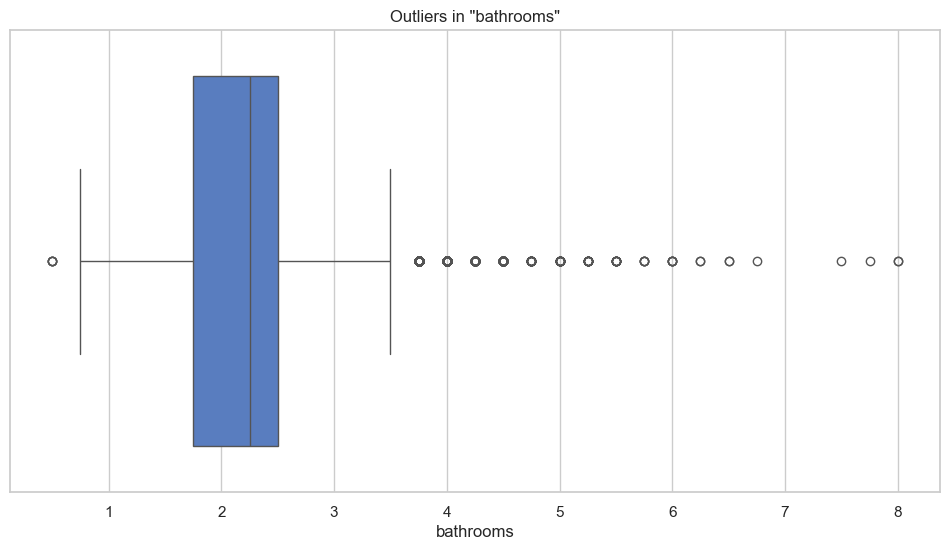

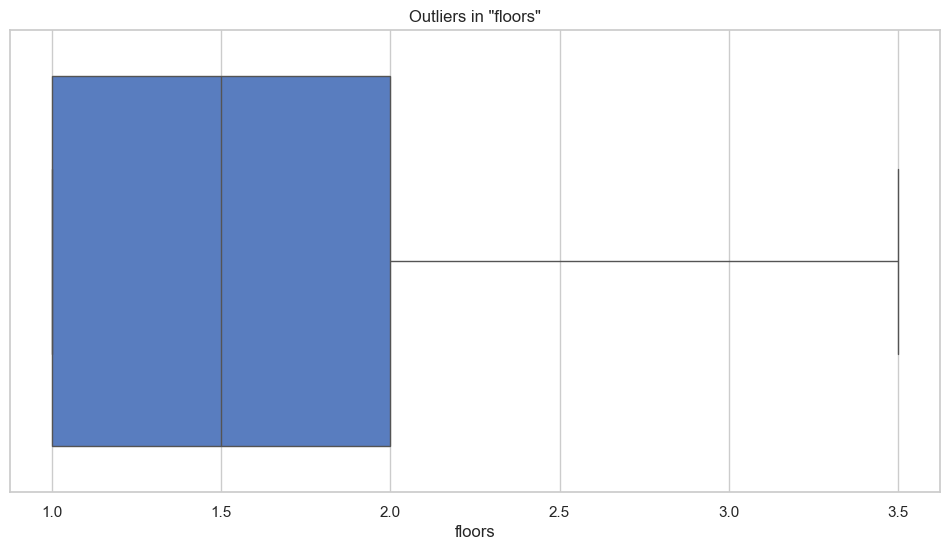

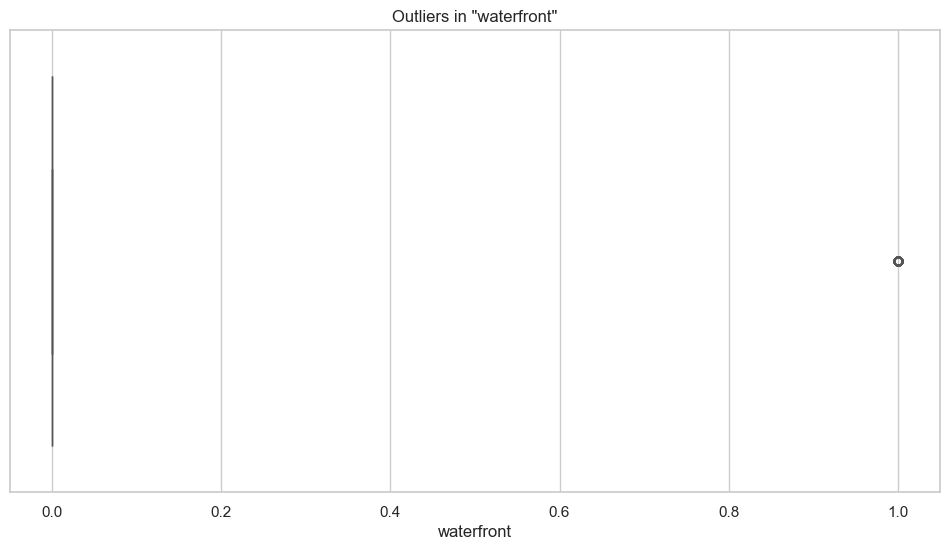

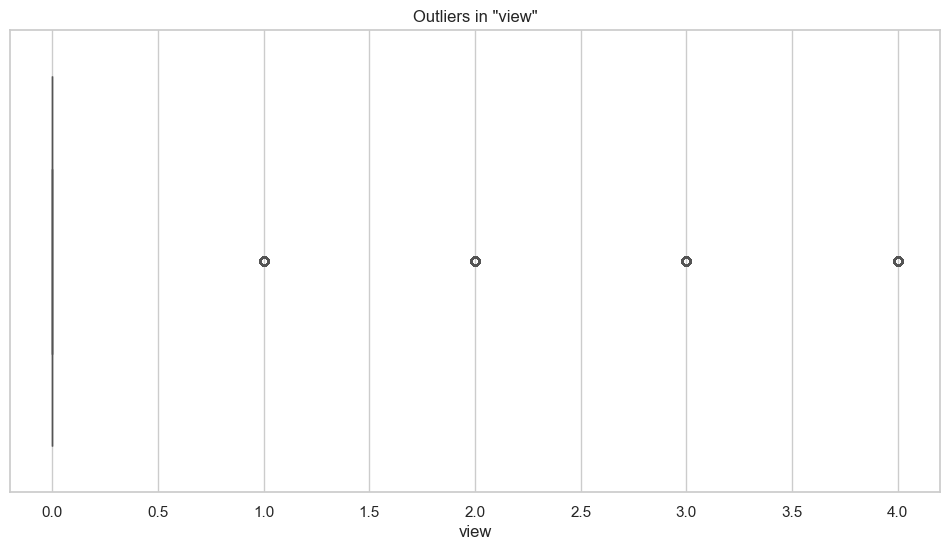

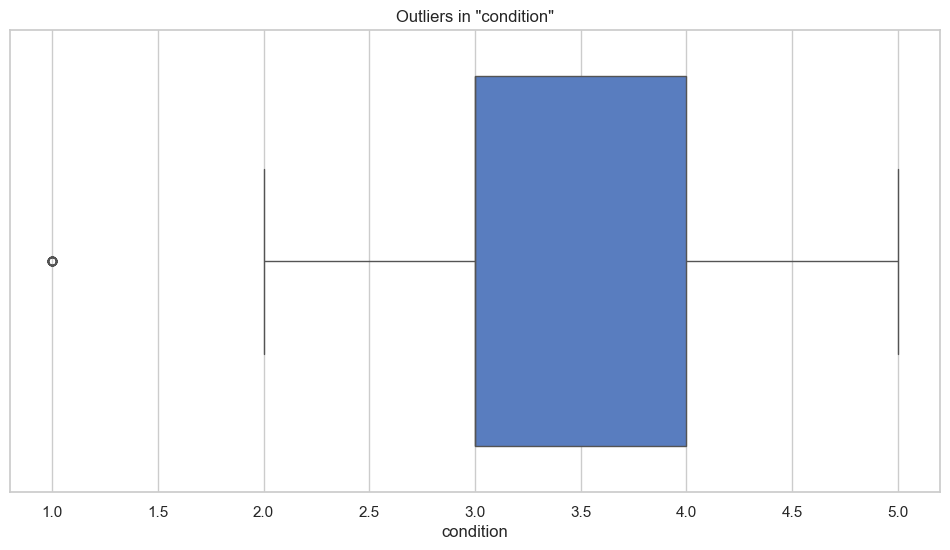

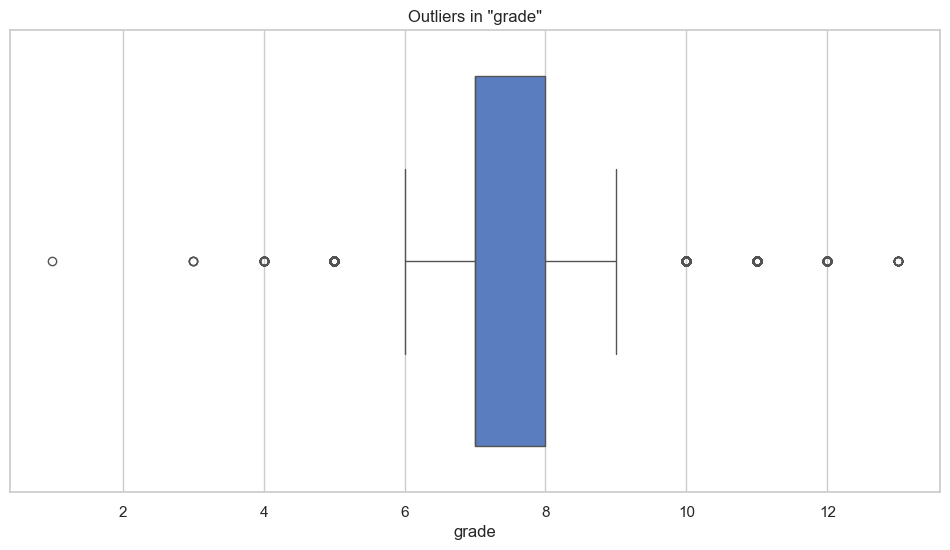

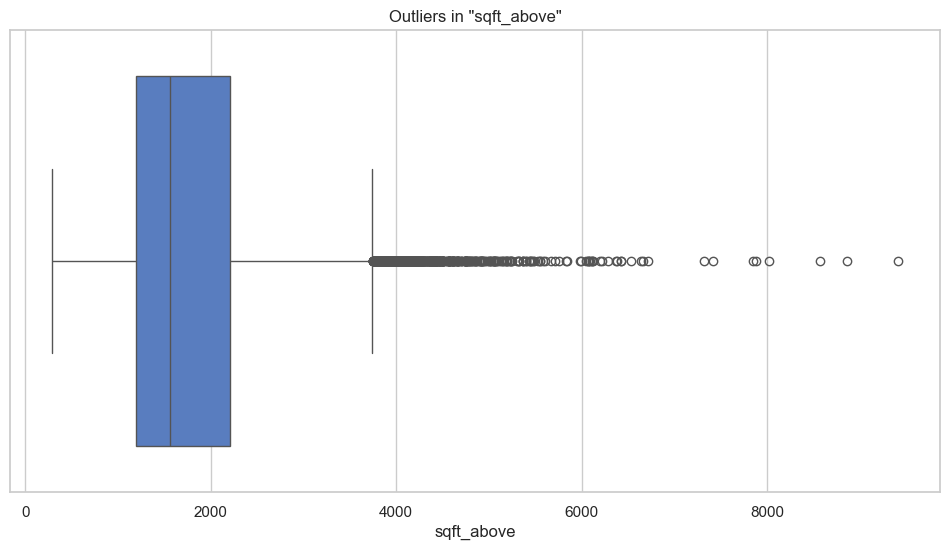

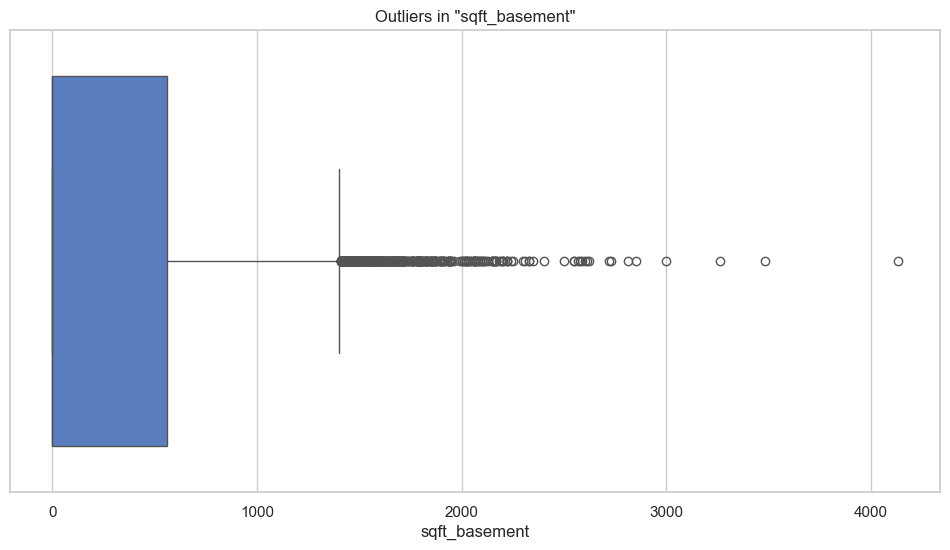

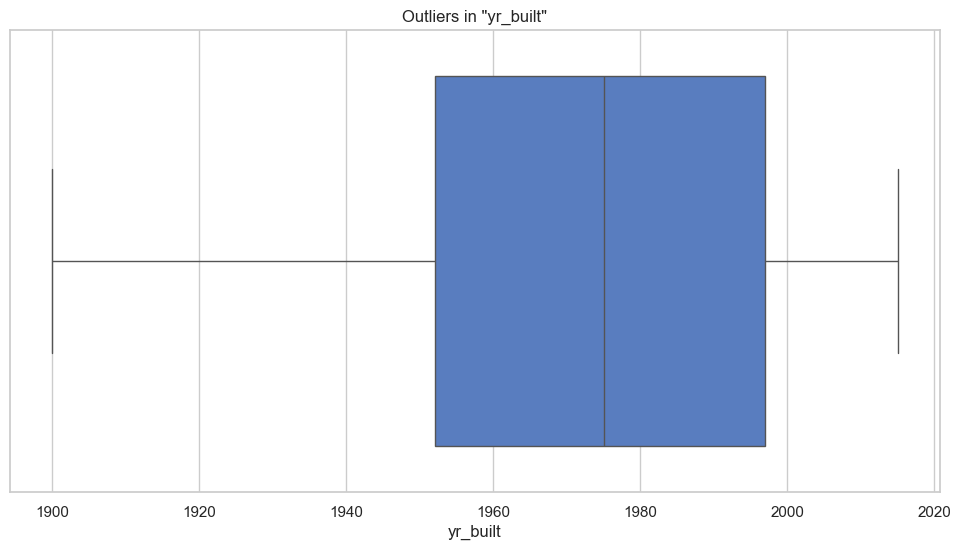

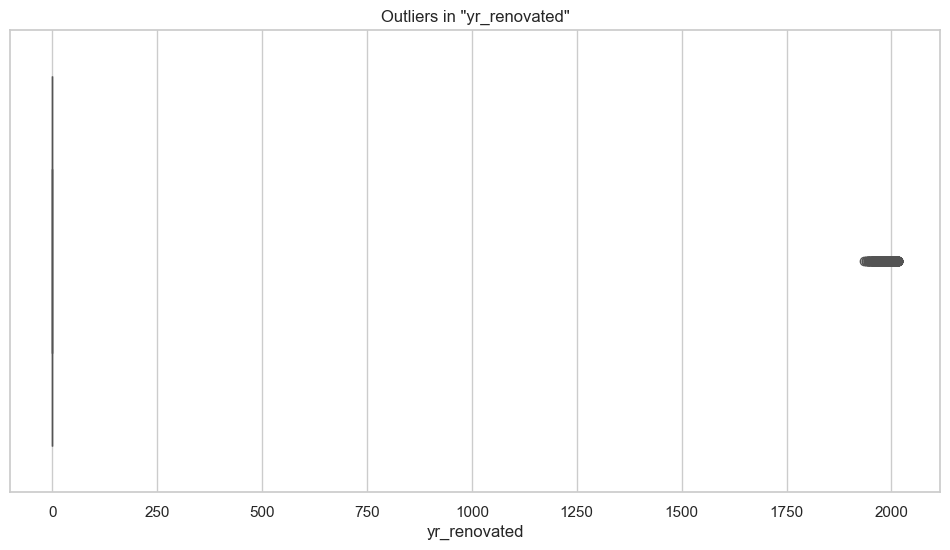

In [7]:
for col in features:
    sns.boxplot(x=df_subset[col])
    plt.title(f'Outliers in "{col}"')
    # Save the plot as a PNG file.
    plt.savefig(f"../reports/figures/eda/part5-boxplot-{col}.png", dpi=300, bbox_inches='tight')
    plt.show()


### Correlation with the target variable

As we saw, we have the following magnitudes of correlation with the target variable "price"

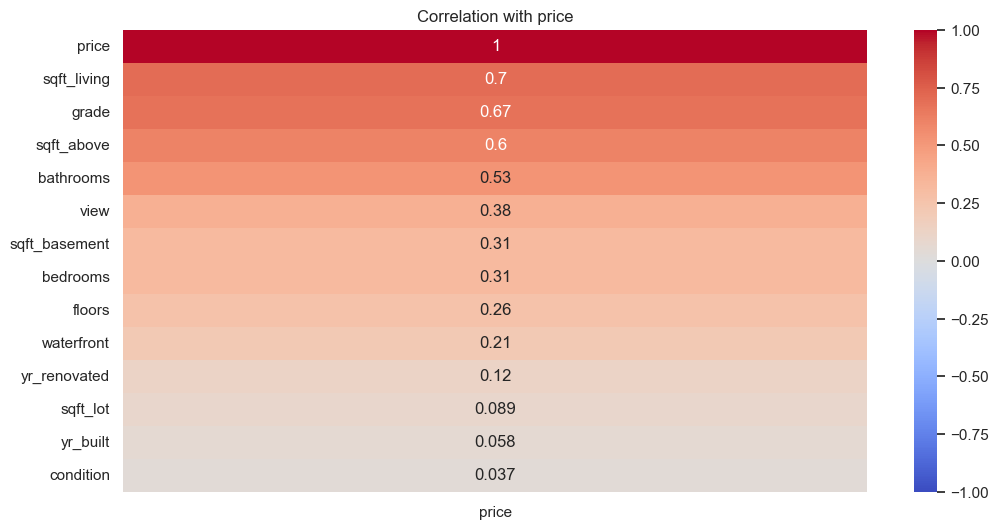

In [14]:
corr = df_subset.corr()
sns.heatmap(corr[[target]].sort_values(by=target, ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with price')
# Save the plot as a PNG file.
plt.savefig(f"../reports/figures/eda/part5-heatmap-correlation.png", dpi=300, bbox_inches='tight')
plt.show()


### Multicollinearity (correlations between features)

Let's analyze multicollinearity

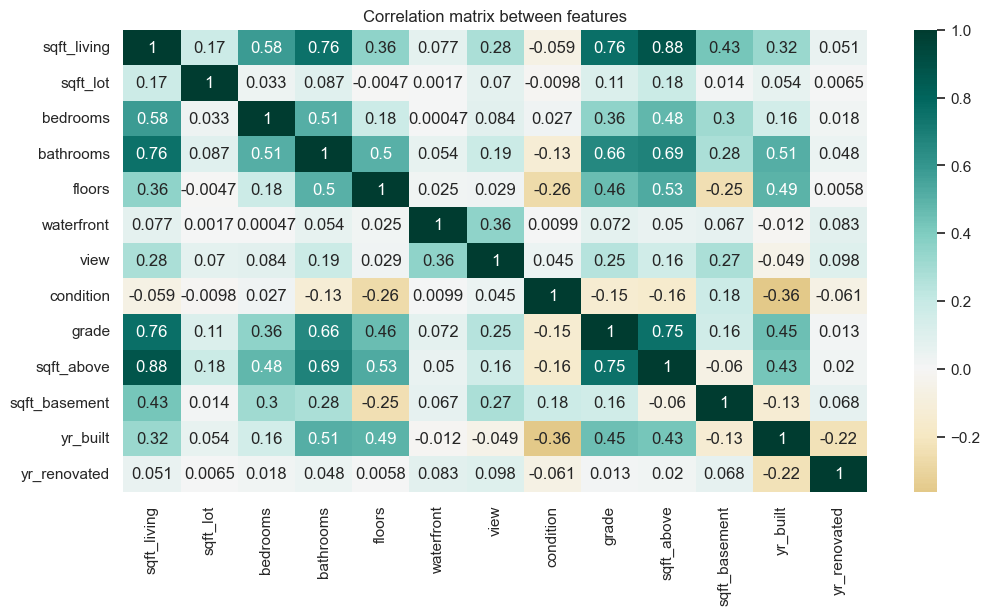

In [9]:
sns.heatmap(df_subset[features].corr(), annot=True, cmap='BrBG', center=0)
plt.title('Correlation matrix between features')
# Save the plot as a PNG file.
plt.savefig(f"../reports/figures/eda/part5-correlation-matrix-features.png", dpi=300, bbox_inches='tight')
plt.show()

What are we looking for here?

Highly correlated variables, e.g. sqft_living and sqft_above.

Opportunities to reduce dimensionality by eliminating or combining variables.

Cardinality analysis

In [87]:
for col in ['view', 'condition', 'grade', 'waterfront', 'floors']:
    print(f'\n{col} - unique values:') 
    print(df_subset[col].value_counts().sort_index())


view - unique values:
view
0    19489
1      331
2      955
3      491
4      292
Name: count, dtype: int64

condition - unique values:
condition
1       29
2      171
3    14005
4     5661
5     1692
Name: count, dtype: int64

grade - unique values:
grade
1        1
3        3
4       29
5      238
6     2032
7     8973
8     6058
9     2608
10    1127
11     393
12      83
13      13
Name: count, dtype: int64

waterfront - unique values:
waterfront
0    21450
1      108
Name: count, dtype: int64

floors - unique values:
floors
1.0    10657
1.5     1902
2.0     8220
2.5      160
3.0      611
3.5        8
Name: count, dtype: int64


This tells me whether I treat those variables as ordinal, categorical, or binary.

Conclusions from this analysis:

* We have unbalanced or "skewed" distributions and need to transform the asymmetric features.

* There are possible features with low variance or unrelated to price.

* There appear to be relationships between features that could imply multicollinearity.

* There are variables that should be combined or eliminated.

In [11]:
# We prepare the data for the model
X = df_subset[features]
y = df_subset[target]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In part 4 we already managed to identify that our regression models, the best algorithm(s) that best fit this type of data, are XGBoost and RandomForest, so we are going to focus on these two candidates.

### Random Forest – Gini Importance

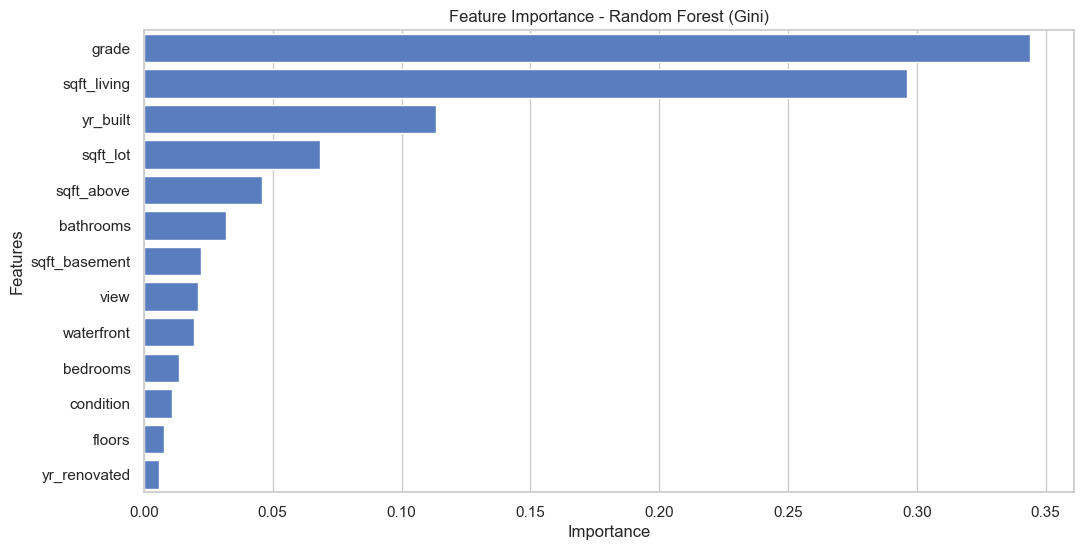

In [12]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

importances_rf = rf_model.feature_importances_
features_importance_rf = pd.Series(importances_rf, index=features).sort_values(ascending=False)

# View
sns.barplot(x=features_importance_rf, y=features_importance_rf.index)
plt.title('Feature Importance - Random Forest (Gini)')
plt.xlabel('Importance')
plt.ylabel('Features')
# Save the plot as a PNG file.
plt.savefig(f"../reports/figures/features_engineering/part5-feature-importance-rf.png", dpi=300, bbox_inches='tight')
plt.show()

With this we can see which variables are the most important for a tree model and if any have very low importance, which we could discard.

### XGBoost – Gain-based Importance

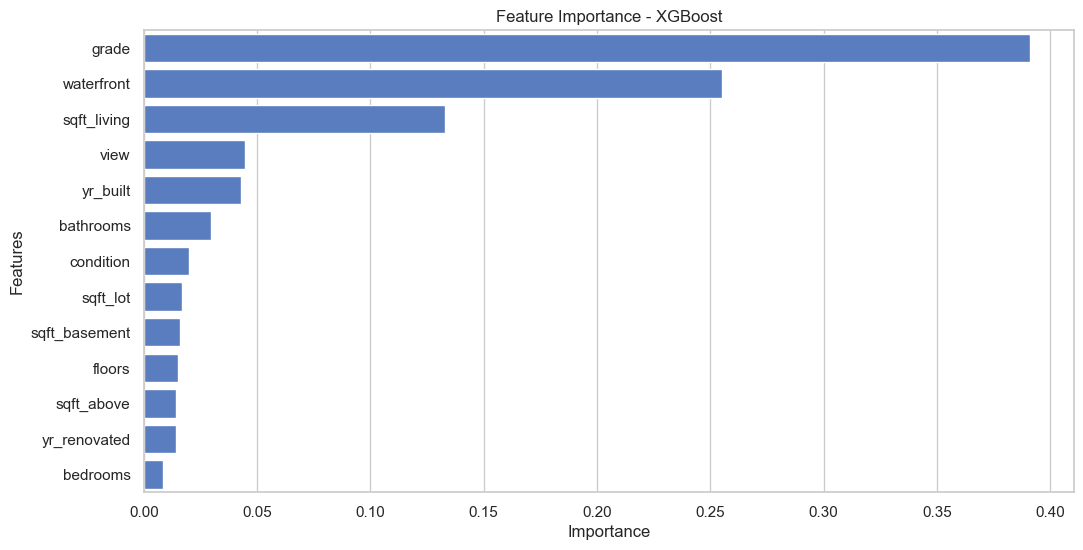

In [13]:
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

importances_xgb = xgb_model.feature_importances_
features_importance_xgb = pd.Series(importances_xgb, index=features).sort_values(ascending=False)

# View
sns.barplot(x=features_importance_xgb, y=features_importance_xgb.index)
plt.title('Feature Importance - XGBoost')
plt.xlabel('Importance')
plt.ylabel('Features')
# Save the plot as a PNG file.
plt.savefig(f"../reports/figures/features_engineering/part5-feature-importance-xgb.png", dpi=300, bbox_inches='tight')
plt.show()

## Permutation Importance

We need to measure the drop in model performance when permuting the values ​​of each variable.

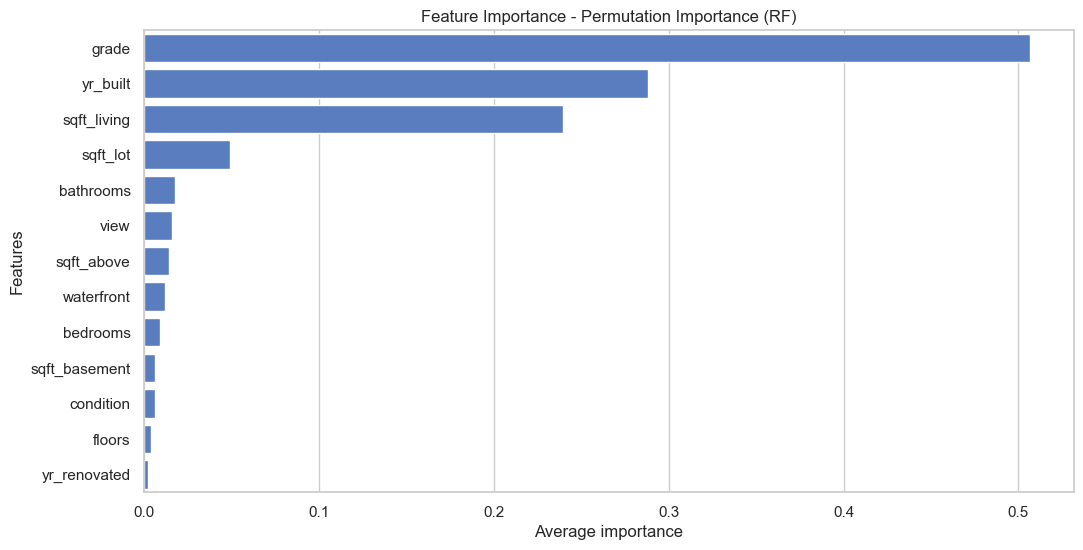

In [15]:
result = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42)

perm_importance = pd.Series(result.importances_mean, index=features).sort_values(ascending=False)

sns.barplot(x=perm_importance, y=perm_importance.index)
plt.title('Feature Importance - Permutation Importance (RF)')
plt.xlabel('Average importance')
plt.ylabel('Features')
# Save the plot as a PNG file.
plt.savefig(f"../reports/figures/features_engineering/part5-feature-importance-permutation.png", dpi=300, bbox_inches='tight')
plt.show()

### We select automatically with SelectFromModel

In [93]:
selector = SelectFromModel(rf_model, threshold="median", prefit=True)
selected_features_rf = X.columns[(selector.get_support())]
print("Features selected by Random Forest:", selected_features_rf.tolist())

Features selected by Random Forest: ['sqft_living', 'sqft_lot', 'bathrooms', 'grade', 'sqft_above', 'sqft_basement', 'yr_built']


With this we select only the strongest features according to relative importance.

### Feature transformation

The objective of this is to correct biases or asymmetric distributions (log-transform) to extract or combine new variables and adequately treat ordinal vs. categorical variables.

As we have already seen, we deal with biased variables.

In [94]:
df['log_sqft_living'] = np.log1p(df['sqft_living'])
df['log_sqft_lot'] = np.log1p(df['sqft_lot'])
df['log_sqft_basement'] = np.log1p(df['sqft_basement'])

Let's create new derived features

In [95]:
df['age'] = 2025 - df['yr_built']
df['is_renovated'] = (df['yr_renovated'] > 0).astype(int)
df['renovation_age'] = np.where(df['yr_renovated'] > 0, 2025 - df['yr_renovated'], 0)
df['total_bath_per_bedroom'] = df['bathrooms'] / df['bedrooms'].replace(0, np.nan)

We reduce collinearity:

``sqft_above`` and ``sqft_living`` are very similar.

In [96]:
df['above_ratio'] = df['sqft_above'] / df['sqft_living']

### Feature final set

After the transformations, our new candidate features are

In [97]:
final_features = [
    'log_sqft_living',
    'log_sqft_lot',
    'log_sqft_basement',
    'bedrooms',
    'bathrooms',
    'floors',
    'waterfront',
    'view',
    'condition',
    'grade',
    'age',
    'is_renovated',
    'renovation_age',
    'above_ratio',
    'total_bath_per_bedroom'
]


### With these steps, we were able to:
* Transform skewed distributions to improve learning.
* Construct new variables that enrich the semantics of the dataset.
* Prepare a set of cleaner, more informative, and redundant features.

## Final Feature Selection Based on Performance Evaluation

We now have a clean df with transformations. Now we create:

In [98]:
#1. Only the most important ones by Gini
features_rf = ['log_sqft_living', 'grade', 'bathrooms', 'view', 'age']

#2. Top of XGBoost
features_xgb = ['log_sqft_living', 'grade', 'bathrooms', 'sqft_above', 'condition']

#3. Full engineered set
features_full = [ 'log_sqft_living', 'log_sqft_lot', 'log_sqft_basement', 'bedrooms',
                 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'age', 
                 'is_renovated', 'renovation_age', 'above_ratio', 'total_bath_per_bedroom'
                 ]

### Cross-evaluation of feature sets

In [99]:
def evaluate_model(X, y, model): 
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error') 
    return -scores.mean()

y = df['price']

results = {}

for label, feature_set in {
    'RF_Selected': features_rf,
    'XGB_Selected': features_xgb,
    'Full_Engineered': features_full
}.items():
    X = df[feature_set]

    rf_rmse = evaluate_model(X, y, RandomForestRegressor(n_estimators=100, random_state=42)) 
    xgb_rmse = evaluate_model(X, y, XGBRegressor(n_estimators=100, random_state=42)) 

    results[label] = { 
        'RF_RMSE': rf_rmse, 
        'XGB_RMSE': xgb_rmse 
    }

results_df = pd.DataFrame(results).T
print(results_df)

                       RF_RMSE       XGB_RMSE
RF_Selected      210480.800425  210462.630570
XGB_Selected     233791.940349  230261.591568
Full_Engineered  195536.876974  195519.920140


We graph the results to better interpret them

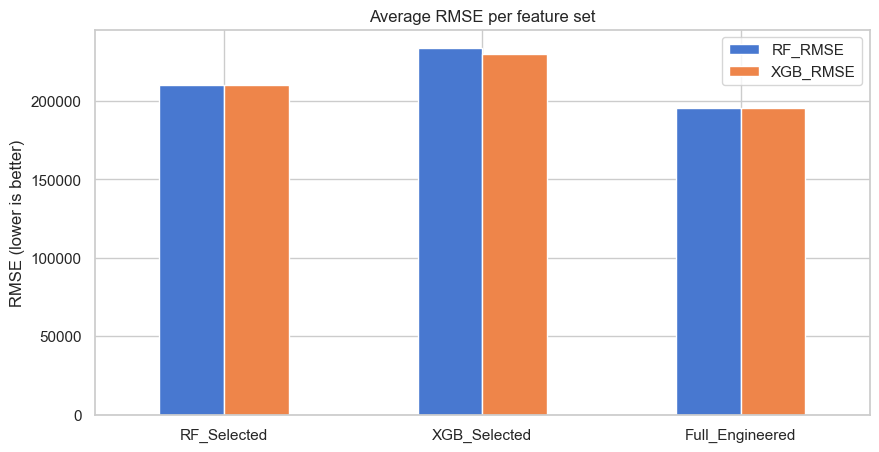

In [ ]:
results_df.plot(kind='bar', figsize=(10, 5))
plt.title('Average RMSE per feature set')
plt.ylabel('RMSE (lower is better)')
plt.grid(True)
plt.xticks(rotation=0)
# Save the plot as a PNG file.
plt.savefig(f"../reports/figures/modeling_and_evaluation/part5-rmse-comparison.png", dpi=300, bbox_inches='tight')
plt.show()

### Automatic search: RFECV

In [101]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rfecv = RFECV(estimator=rf, step=1, cv=5, scoring='neg_root_mean_squared_error')
rfecv.fit(df[features_full], y)

selected_rfecv = df[features_full].columns[rfecv.support_]
print("Features selected by RFECV:", selected_rfecv.tolist())

Features selected by RFECV: ['log_sqft_living', 'log_sqft_lot', 'log_sqft_basement', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'age', 'renovation_age', 'above_ratio', 'total_bath_per_bedroom']


We now have:

* Quantitative metrics comparing different subsets of variables.

* Objective evidence for choosing the final features.

* Robust validation that the transformations actually added value.

We define transformations

In [102]:
# log transformations
log_features = ['sqft_living', 'sqft_lot', 'sqft_basement']
log_transformer = FunctionTransformer(np.log1p, validate=True)

# Other columns without transformation
passthrough_features = [ 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 
                        'condition', 'grade']

preprocessor = ColumnTransformer(transformers=[('log', log_transformer, log_features), 
                                               ('pass', 'passthrough', passthrough_features)
                                               ])

We create a complete pipeline that includes the created features

In [103]:
def add_engineered_features(X): 
    X = X.copy() 
    X['age'] = 2025 - X['yr_built'] 
    X['is_renovated'] = (X['yr_renovated'] > 0).astype(int) 
    X['renovation_age'] = np.where(X['yr_renovated'] > 0, 2025 - X['yr_renovated'], 0) 
    X['total_bath_per_bedroom'] = X['bathrooms'] / X['bedrooms'].replace(0, np.nan) 
    X['above_ratio'] = X['sqft_above'] / X['sqft_living'].replace(0, np.nan) 
    return X

class FeatureEngineer(BaseEstimator, TransformerMixin): 
    def fit(self, X, y=None): 
        return self 

    def transform(self, X): 
        return add_engineered_features(X)

# Complete pipeline
full_pipeline = make_pipeline(FeatureEngineer(), 
                              preprocessor
                              )

Save the pipeline

In [104]:
import joblib

joblib.dump(full_pipeline, '../models/feature_pipeline.pkl')
print("Saved pipeline")

Saved pipeline


## Evaluate the model

In [105]:
y = df['price']
X = df.drop(columns=['price'])

In [106]:
# Load the pipeline
pipeline = joblib.load('../models/feature_pipeline.pkl')

In [107]:
# Apply transformations
X_transformed = pipeline.fit_transform(X)

# Train the final model
model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_transformed, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [108]:
# Prediction on the same data (or on a validation set if you have one)
y_pred = model.predict(X_transformed)

# R2 score
r2 = r2_score(y, y_pred)
print(f"R² of the final model: {r2:.4f}")

R² of the final model: 0.8503


In [109]:
# Show comparison of some predictions
comparison = pd.DataFrame({'Actual Price': y,
                           'Predicted Price': y_pred.astype(int)
                           })
print(comparison.head(10))

   Actual Price  Predicted Price
0      221900.0           368641
1      538000.0           565081
2      180000.0           216366
3      604000.0           527210
4      510000.0           416115
5     1225000.0          1287435
6      257500.0           318991
7      291850.0           272233
8      229500.0           303121
9      323000.0           340832


### Also visually:

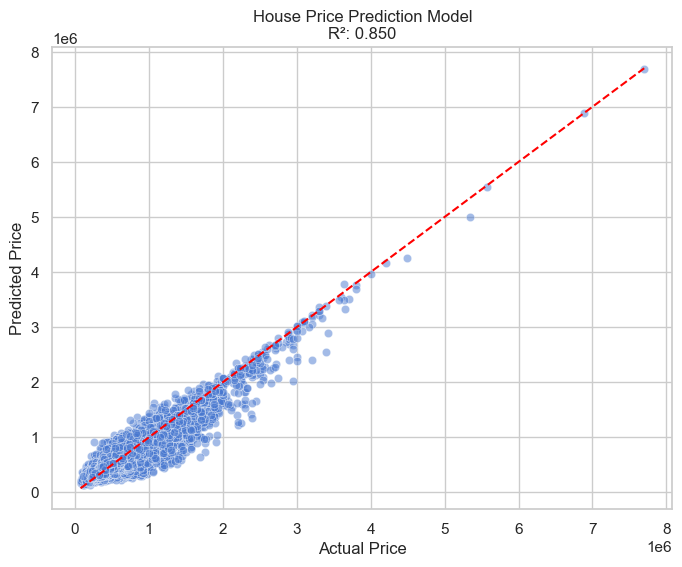

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y, y=y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='red')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(f'House Price Prediction Model\nR²: {r2:.3f}')
plt.grid(True)
# Save the plot as a PNG file.
plt.savefig(f"../reports/figures/modeling_and_evaluation/part5-prediction-scatter.png", dpi=300, bbox_inches='tight')
plt.show()

### Save model

In [111]:
joblib.dump(model, '../models/model_xgb_price_houses.pkl')
print("Saved model")

Saved model


<hr>

## Result Final

```` 
In the technical context:

The model analyzes several aspects of a home, such as the square footage, the year it was built, whether it was renovated, and the perceived quality, and predicts the price with an accuracy of 0.85%. In the graph, each point represents a home: the closer it is to the red line, the more accurate the model is. As we can see, most are very close, indicating that the model works relatively well.

````
In a business context:

Our model predicts the price of a house with an accuracy of 85%. That is, if the actual value of a house were $200,000, the model would typically be pretty close, within a reasonable margin of error for real estate operations.

<hr>

## Author

<a href="https://www.linkedin.com/in/flavio-aguirre-12784a252/">**Flavio Aguirre**</a><br>
<a href="https://coursera.org/share/e27ae5af81b56f99a2aa85289b7cdd04">***Data Scientist***</a>